In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
from tqdm import tqdm
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from scipy.ndimage.filters import gaussian_filter, uniform_filter
tqdm.pandas()
import cmocean
import matplotlib as mpl

C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\tqdm\std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd

In [4]:
PATH_RAW = 'D:/Workshop/PhD/Data/ViaLactea/PPMAP_Results/'
PATH_64x85 = 'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px_rejigged_fulltile/'
PATH_32x17 = 'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/32px_rejigged_fulltile_64pxwindow/'
PATH_32x85 = 'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/32px_rejigged_fulltile/'

In [5]:
no_files = len(os.listdir(PATH_32x17+'DataCubes'))
no_files

163

In [6]:
def average_field(field, filter_size, norm = False):
    field_noNANs = np.nan_to_num(field)
    mask = field_noNANs.copy()
    mask[field_noNANs==0] = np.nan
    mask[field_noNANs!=0] = 1
    
    avg_field = uniform_filter(field_noNANs, size=filter_size, mode='mirror')*mask
    
    if norm:
        return np.log10(avg_field)
    return avg_field

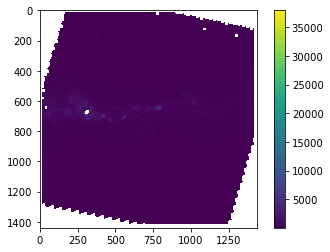

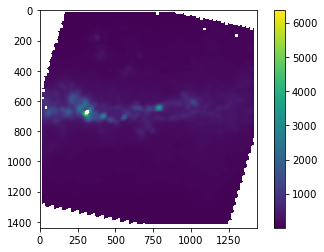

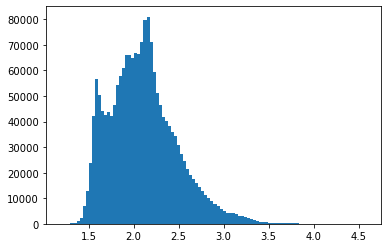

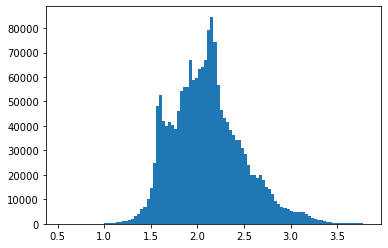

In [7]:
cube_32x85 = pickle.load(open(f'{PATH_32x85}/DataCubes/{os.listdir(PATH_32x85+"DataCubes")[0]}','rb'))

col_dens = cube_32x85[0]

plt.figure()
plt.imshow(col_dens)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(average_field(col_dens, 32))
plt.colorbar()
plt.show()

plt.figure()
plt.hist(np.log10(col_dens.flatten()), bins=100)
plt.show()

plt.figure()
plt.hist(np.log10(average_field(col_dens, 32).flatten()), bins=100)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [06:50<00:00,  2.52s/it]


$\Delta H: 0.0067000869847834085$
$\Delta S: 0.017991222366690637$
$\Delta \Sigma: 0.01444456294178964$


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [09:03<00:00,  3.33s/it]


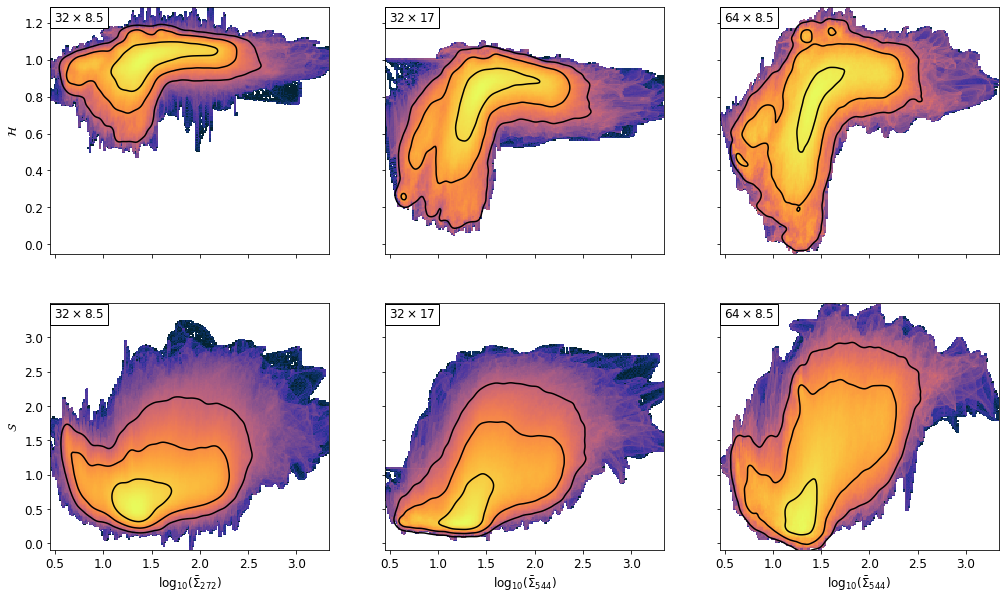

In [8]:
plt.rcParams.update({'font.size': 12})
f,ax = plt.subplots(2,3, figsize=(17,10), sharex = True, sharey = 'row')

x = 0.015
y = 0.942

sigma = 2

normalise = True

df = pd.DataFrame(columns = ['H_64x85','S_64x85', 'col_dens'])
for i in tqdm(range(no_files)):
    
    cube_64x85 = pickle.load(open(f'{PATH_64x85}/DataCubes/{os.listdir(PATH_64x85+"DataCubes")[i]}','rb'))
    
    temp_df = pd.DataFrame()
    temp_df['H_64x85'] = np.pad(cube_64x85[1],((32,31),(32,31)), 'constant', constant_values = np.nan).flatten()
    temp_df['S_64x85'] = np.pad(cube_64x85[2],((32,31),(32,31)), 'constant', constant_values = np.nan).flatten()
    temp_df['col_dens'] = average_field(cube_64x85[0], 64, normalise).flatten()

    temp_df = temp_df.dropna()
    df = df.append(temp_df)
    
H_min = df['H_64x85'].min()
H_max = df['H_64x85'].max()

S_max = df['S_64x85'].max()
S_min = df['S_64x85'].min()

col_max = df['col_dens'].max()a
col_min = df['col_dens'].min()    
    
S_bins = np.linspace(S_min, S_max, 201)
H_bins = np.linspace(H_min, H_max, 201)
col_bins = np.linspace(col_min, col_max, 201)

print(fr'$\Delta H: {H_bins[1]-H_bins[0]}$')
print(fr'$\Delta S: {S_bins[1]-S_bins[0]}$')
print(fr'$\Delta \Sigma: {col_bins[1]-col_bins[0]}$')

counts, xbins, ybins, image = ax[0,2].hist2d(df['col_dens'],df['H_64x85'],bins=[col_bins,H_bins], cmap=cmocean.cm.thermal, norm=mpl.colors.LogNorm())

contours = ax[0,2].contour(gaussian_filter(counts.transpose(),sigma), 
                extent = [xbins.min(),xbins.max(),ybins.min(),ybins.max()],
                levels = [1000,10000,70000],
                           colors='k'
               )

ax[0,2].text(x, y, r'$64\times 8.5$', transform=ax[0,2].transAxes,bbox = dict(facecolor='white'))

counts, xbins, ybins, image = ax[1,2].hist2d(df['col_dens'],df['S_64x85'],bins=[col_bins,S_bins], cmap=cmocean.cm.thermal, norm=mpl.colors.LogNorm())


contours = ax[1,2].contour(gaussian_filter(counts.transpose(),sigma), 
                extent = [xbins.min(),xbins.max(),ybins.min(),ybins.max()],
                levels = [1000,10000,70000],
                colors='k'
               )

ax[1,2].set_xlabel(r'$\log_{10}(\bar{\Sigma}_{544})$')
ax[1,2].text(x, y, r'$64\times 8.5$', transform=ax[1,2].transAxes,bbox = dict(facecolor='white'))

#########################################################################################################
#########################################################################################################
#########################################################################################################

df = pd.DataFrame(columns = ['H_32x85','S_32x85', 'col_dens'])
for i in tqdm(range(no_files)):
    
    cube_32x85 = pickle.load(open(f'{PATH_32x85}/DataCubes/{os.listdir(PATH_32x85+"DataCubes")[i]}','rb'))

    temp_df = pd.DataFrame()
    temp_df['H_32x85'] = np.pad(cube_32x85[1],((16,15),(16,15)), 'constant', constant_values = np.nan).flatten()
    temp_df['S_32x85'] = np.pad(cube_32x85[2],((16,15),(16,15)), 'constant', constant_values = np.nan).flatten()
    temp_df['col_dens'] = average_field(cube_32x85[0], 32, normalise).flatten()

    temp_df = temp_df.dropna()
    df = df.append(temp_df)

    
counts, xbins, ybins, image = ax[0,0].hist2d(df['col_dens'],df['H_32x85'],bins=[col_bins,H_bins], cmap=cmocean.cm.thermal, norm=mpl.colors.LogNorm())


contours = ax[0,0].contour(gaussian_filter(counts.transpose(),sigma), 
                extent = [xbins.min(),xbins.max(),ybins.min(),ybins.max()],
                levels = [1000,10000,70000],
                           colors='k'
               )

ax[0,0].set_ylabel(r'$\mathcal{H}}$')
ax[0,0].text(x, y, r'$32\times 8.5$', transform=ax[0,0].transAxes,bbox = dict(facecolor='white'))

H_max = df['H_32x85'].max()
col_max = df['col_dens'].max()
col_min = df['col_dens'].min()

counts, xbins, ybins, image = ax[1,0].hist2d(df['col_dens'],df['S_32x85'],bins=[col_bins,S_bins], cmap=cmocean.cm.thermal, norm=mpl.colors.LogNorm())

contours = ax[1,0].contour(gaussian_filter(counts.transpose(),sigma), 
                extent = [xbins.min(),xbins.max(),ybins.min(),ybins.max()],
                levels = [1000,10000,70000],
                           colors='k'
               )

ax[1,0].set_xlabel(r'$\log_{10}(\bar{\Sigma}_{272})$')
ax[1,0].set_ylabel(r'$\mathcal{S}}$')
ax[1,0].text(x, y, r'$32\times 8.5$', transform=ax[1,0].transAxes,bbox = dict(facecolor='white'))

#########################################################################################################
#########################################################################################################
#########################################################################################################

df = pd.DataFrame(columns = ['H_32x17','S_32x17', 'col_dens'])
for i in tqdm(range(no_files)):
    
    cube_32x17 = pickle.load(open(f'{PATH_32x17}/DataCubes/{os.listdir(PATH_32x17+"DataCubes")[i]}','rb'))

    temp_df = pd.DataFrame()
    temp_df['H_32x17'] = np.pad(cube_32x17[1],((32,31),(32,31)), 'constant', constant_values = np.nan).flatten()
    temp_df['S_32x17'] = np.pad(cube_32x17[2],((32,31),(32,31)), 'constant', constant_values = np.nan).flatten()
    temp_df['col_dens'] = average_field(cube_32x17[0], 32, normalise).flatten()
    temp_df = temp_df.dropna()
    df = df.append(temp_df)
    
counts, xbins, ybins, image = ax[0,1].hist2d(df['col_dens'],df['H_32x17'],bins=[col_bins,H_bins], cmap=cmocean.cm.thermal, norm=mpl.colors.LogNorm())

contours = ax[0,1].contour(gaussian_filter(counts.transpose(),sigma), 
                extent = [xbins.min(),xbins.max(),ybins.min(),ybins.max()],
                levels = [1000,10000,70000],
                           colors='k'
               )

ax[0,1].text(x, y, r'$32\times 17$', transform=ax[0,1].transAxes,bbox = dict(facecolor='white'))

counts, xbins, ybins, image = ax[1,1].hist2d(df['col_dens'],df['S_32x17'],bins=[col_bins,S_bins], cmap=cmocean.cm.thermal, norm=mpl.colors.LogNorm())

contours = ax[1,1].contour(gaussian_filter(counts.transpose(),sigma), 
                extent = [xbins.min(),xbins.max(),ybins.min(),ybins.max()],
                levels = [1000,10000,70000],
                           colors='k'
               )

ax[1,1].set_xlabel(r'$\log_{10}(\bar{\Sigma}_{544})$')
ax[1,1].text(x, y, r'$32\times 17$', transform=ax[1,1].transAxes,bbox = dict(facecolor='white'))


plt.savefig('D:\Workshop\PhD\Papers\HiGal paper\Images/HSvnormofSigmaNew.png',bbox_inches="tight")
plt.show()

In [9]:
print(xbins, ybins)

[0.45034918 0.46479374 0.47923831 0.49368287 0.50812743 0.522572
 0.53701656 0.55146112 0.56590569 0.58035025 0.59479481 0.60923937
 0.62368394 0.6381285  0.65257306 0.66701763 0.68146219 0.69590675
 0.71035131 0.72479588 0.73924044 0.753685   0.76812957 0.78257413
 0.79701869 0.81146326 0.82590782 0.84035238 0.85479694 0.86924151
 0.88368607 0.89813063 0.9125752  0.92701976 0.94146432 0.95590888
 0.97035345 0.98479801 0.99924257 1.01368714 1.0281317  1.04257626
 1.05702083 1.07146539 1.08590995 1.10035451 1.11479908 1.12924364
 1.1436882  1.15813277 1.17257733 1.18702189 1.20146645 1.21591102
 1.23035558 1.24480014 1.25924471 1.27368927 1.28813383 1.3025784
 1.31702296 1.33146752 1.34591208 1.36035665 1.37480121 1.38924577
 1.40369034 1.4181349  1.43257946 1.44702402 1.46146859 1.47591315
 1.49035771 1.50480228 1.51924684 1.5336914  1.54813597 1.56258053
 1.57702509 1.59146965 1.60591422 1.62035878 1.63480334 1.64924791
 1.66369247 1.67813703 1.69258159 1.70702616 1.72147072 1.7359152

In [10]:
np.linspace(S_min, S_max, 201) == ybins

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,